<a href="https://colab.research.google.com/github/PhilippShemetov/DetectAudio/blob/main/DetectAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Первая лабораторная

##Подключение библиотек

In [127]:
import librosa
import math
import pandas as pd
import numpy as np
import scipy 
import scipy.fft
from scipy.fft import fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import re
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

##Скачиваем набор данных

In [24]:
!wget https://drive.google.com/u/0/uc?id=1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ&export=download&confirm=t -P /content/gdrive/MyDrive/AudioDetect

/bin/bash: -P: command not found
--2022-03-20 18:12:10--  https://drive.google.com/u/0/uc?id=1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ
Resolving drive.google.com (drive.google.com)... 172.253.122.139, 172.253.122.138, 172.253.122.100, ...
Connecting to drive.google.com (drive.google.com)|172.253.122.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ [following]
--2022-03-20 18:12:10--  https://drive.google.com/uc?id=1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘uc?id=1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ’

uc?id=1OXZ-7SKtOKZJ     [ <=>                ]   2.13K  --.-KB/s    in 0.001s  

2022-03-20 18:12:10 (3.63 MB/s) - ‘uc?id=1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ’ saved [2185]



In [ ]:
!sudo rm -rf /content/audioset_v1_embeddings/*

In [ ]:
!wget http://storage.googleapis.com/us_audioset/youtube_corpus/v1/features/features.tar.gz -P /content/gdrive/MyDrive/AudioDetect
!tar -xvzf /content/gdrive/MyDrive/AudioDetect/features.tar.gz

##Подключаем гугл диск

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Читаем набор данных c индексами звуков


In [66]:
audio_set = pd.read_csv('/content/gdrive/MyDrive/AudioDetect/train.csv', skiprows = 1, header=None)
audio_set.columns = ['fname','label']

In [ ]:
audio_set

In [74]:
wav,sr = librosa.load('/content/gdrive/MyDrive/AudioDetect/Gunshots.wav')

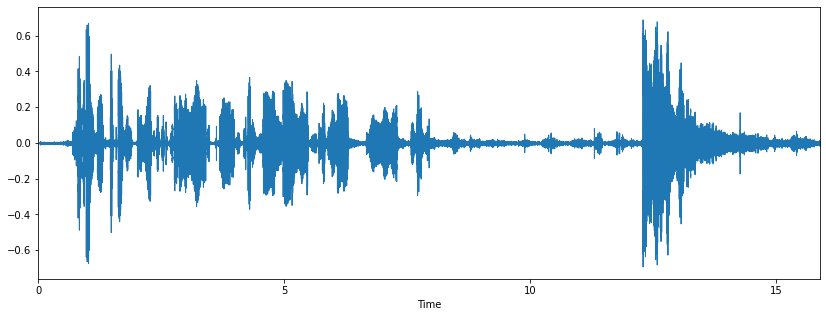

In [75]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

##Разделяем на окна

In [110]:
window_sec = len(wav) // sr
print(window_sec)
set_of_samples = []
mod_var = 0
for i in range(window_sec+1):
  if(sr *(i+1) // len(wav)):
    mod_var = sr * (i+1) % len(wav)
  set_of_samples.append(wav[sr*i:sr*(i+1) - mod_var])
print(len(set_of_samples))
ipd.Audio(set_of_samples[12], rate=sr)

15
16


##Фурье преобразование

In [111]:
def mel(spec):
    spec = 1125 * np.log(1 + spec/700)
    return spec

0 : 38764.426764231175
1 : 32430.993317887653
2 : 28215.6764317418
3 : 24390.01258618757
4 : 27717.295329378685
5 : 29702.56544700975
6 : 21137.440328158613
7 : 17632.097493714886
8 : 5945.255858725519
9 : 3174.181433886639
10 : 3579.016565584825
11 : 4883.514723300716
12 : 100971.02571895346
13 : 36348.708085131366
14 : 10144.732705013885
15 : 4453.499486086366
11025


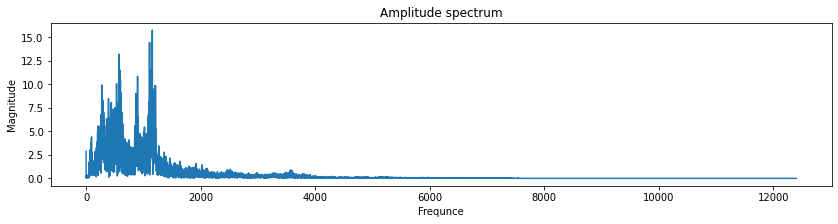

In [150]:
count = 0
for sample in set_of_samples:
  
  fft_audio = abs(fft(sample))
  N = len(sample)
#draw_spec(fft_audio[:sr//2])
  fft_audio = abs(fft(sample))[:sr//2]
  freq_lst = []
  for k in range(len(fft_audio)):
    freq_lst.append(sr/N * k)
  print(count,":",sum(fft_audio))
  count+=1
draw_spec_to_freq(fft_audio,freq_lst)
#stft_db = librosa.amplitude_to_db(mel(abs(stft)))
#plt.figure(figsize=(15,10))
#librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
#print(np.where(stft_db>-4,stft_db,0))

In [142]:
# Теперь будем рисовать сигнал в частотной области
def draw_spec(spec, name=None, draw_A=True, figsize=(14, 3)):
    draw_func = plt.plot
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = abs(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return

def draw_spec_to_freq(spec_amp, freq_q, name=None, figsize=(14, 3)):
    print(len(freq_q))
    plt.figure(figsize=figsize)
    plt.title("Amplitude spectrum")
    plt.plot(freq_q, spec_amp[:len(freq_q)])
    plt.ylabel("Magnitude")
    plt.xlabel("Frequnce")
    if name is not None:
        plt.legend([name])
    plt.show()


[Text(0.5, 1.0, 'MFCC')]

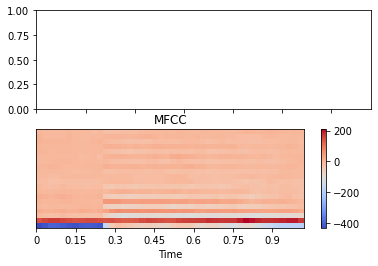

In [123]:
mfccs = librosa.feature.mfcc(set_of_samples[12])
#print(mfccs)
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

#Лабораторная работа №1

##Формируем словарь звуков

In [73]:
wave_dict = {}
sr_dict = {}
list_of_files = sorted(glob('/content/gdrive/MyDrive/AudioDetect/train/*.wav'))
for path in list_of_files:
  index = re.search(r"\d\w+(\.wav)", path).group(0)
  wav,sr = librosa.load(path)
  wave_dict[index] = wav
print(len(wave_dict))


KeyboardInterrupt: ignored